In [6]:
import time
import datetime
import pyautogui
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import os
import re #Searches strings



#Set this to the attenuator value that gives the energy we require. The program will change the att in such a way 
#as to maintain the same amount of energy
initial_att_value = 1.0
#Desired tolerance, changes the attenuator if the new power value measured is +/- 2.5% of the previous one
tolerance = 0.025 #2.5% plus or minus
#Data recording interval in seconds (needs to be the same as in the labview program)
data_interval = 10
#Calibration points, minimum 3, max = np.floor((45-initial_att_value)/2), default: 4
n_points = 4

#Data position, this is where the information of the laser power is stored in the data file
pow_pos = 22
att_pos = 39

data_dir = "C:\\Users\\PVD User\\Documents\\PVD Products\\Data Logs\\"
#data_dir = os.getcwd() #Use for testing, to read data in the same directory

def return_datetime():
    """
    Provides a string of the date and time in the format YYYY/MM/DD HH:MM:SS
    Requires:
    * Nothing
    
    Returns:
    * date_time (string): Returns the date and time in the following format YYYY/MM/DD HH:MM:SS
    """
    
    date_time = datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S')
    return date_time


def searcher(string):
    """
    Finds any file whose filename matches today's date.
    requires a string to search
    Requires:
    * string (string): Object in which to search
    
    Returns:
    * search results (string): Returns results that match the search criteria
    """
    
    file = re.compile(time.strftime("%d%m20%y"))
    return file.search(string)


def file_adder(directory = data_dir):
    """
    Returns a list with all the csv files in the directory
    Requires:
    * directory (string): Path in which to search for files
    
    Returns:
    * files (list): List with all the paths + filenames 
    """
    
    files =[]
    for elements in os.listdir(directory):
        if searcher(elements):
            print(elements)
            files.append(os.path.join(directory, elements))
    return files


def file_get(target_dir = data_dir):
    """
    Opens the file that matches the search on this directory
    Requires:
    * Nothing
    
    Returns:
    * file_handle (file object): File object, open in read mode
    """
    
    csv_f = file_adder(target_dir)
    csv = csv_f[len(csv_f)-1]
    print("Opening file: {}".format(csv))
    file_handle = open(csv, "r")
    return file_handle


def convert_to_np_arr(str_list):
    """
    Converts a string list into a numpy array. If it is unable to convert an element, will place a -1 to conserve the
    original list size
    
    Requires:
    * str_list (list of strings)
    
    Returns:
    * np_arr(numpy array of the same size as the original list)
    
    """
    np_arr = np.zeros(len(str_list))
    for i in range(0, len(str_list), 1):
        try:
            num = float(str_list[i])
            np_arr[i] = num
        except:
            np_arr[i] = -1.0
    
    return np_arr

def round_array(array, decimals):
    """
    Rounds the elements of a given array
    Requires:
    * array (array, list): An array or list with elements suceptible to be rounded (i.e. floats)
    * decimals (integer): Number of decimal places to round the array
    
    Returs:
    * array (array, list): Returns the previous array with rounded elements to the specified number of decimals
    """
    for i in range(0, len(array)):
        array[i] = round(array[i], decimals)
    
    return array
    
def process_line(line, token = '\t'):
    """
    Converts a line into a list of elements separated around the a token value default: tabulation (\t)
    Requires:
    * line (string): This is the line to be split
    * token (char, optional): This is the character that signals the place where the line should be split
    
    Returns:
    * line (list of strings): Returns a list where each element is a string, obtained by splitting the 
      line around the token
    """
    line = line.split(token)
    for i in range(0, len(line), 1):
        line[i] = line[i].strip()
    
    return line


def line_get(file_handle, timeout = data_interval):
    """
    Returns a generator that endlessly reads a file while occupying constant memory. If there is nothing to be read, it
    will wait for a set period (timeout)
    
    Requires:
    * file_handle (file object): Requires an open file in read mode
    * data_interval(integer, optional)
    
    Returns:
    * line (generator object): Returns an endless generator that provides lines each time the next() method it's called
    """

    file_handle.seek(0,2) #Change to 0,2 if only newest lines are of interest or 0,1 if we want to read from the beginning
    while True:
        line = file_handle.readline()
        if not line:
            time.sleep(timeout)
            continue
        yield line


def return_att_pow_value(line, att_pos = att_pos, pow_pos = pow_pos):
    """
    Helper function to extract the attenuator and power values from the data file
    Requires:
    * line (string): Line of data obtained from the data file
    * att_pos (int, optional): The position of the attenuator parameter in the data file
    * pow_pos (int, optional): The position of the power parameter in the data file
    
    Returns:
    * np_array[att_pos] (float): Value of the attenuator according to the data file
    * np_array[pow_pos] (float): Value of the power, according to the data file
    """
    line = process_line(line)
    np_array = convert_to_np_arr(line)
    return (np_array[att_pos], np_array[pow_pos])
    

def change_attenuator(val):
    """
    Attempts to change the attenuator value by moving the mouse to the Laser tab in the program, then entering the 
    attenuator value and finally clicking in set position
    Requires:
    * value (float): The new attenuator value
    
    Returns:
    * Nothing
    """
    
    try:
        value = str(val)
        #take a screenshot
        im=pyautogui.screenshot()
        #Locate the laser tab
        pyautogui.moveTo(200,200)
        obj = pyautogui.locateOnScreen('laser_tab.bmp') 
        pyautogui.moveTo(obj[0], obj[1], 0.05) #Moves the mouse to the upper left corner of the obj
        pyautogui.moveRel(obj[2]/2, obj[3]/2, 0.05) #Moves the mouse to the middle of the detected obj
        pos = pyautogui.position()
        pyautogui.click(pos[0], pos[1], button = 'left') #Clicks on the tab
       
        #In laser tab find the att position tab
        pyautogui.moveTo(200,200)
        obj = pyautogui.locateOnScreen('degrees_sp.bmp')
        pyautogui.moveTo(obj[0], obj[1], 0.05) #Moves the mouse to the upper left corner of the obj
        pyautogui.moveRel(10, obj[3] * 3/4, 0.05) #Moves the mouse to the middle in y direction and 10 pixels right
        pos = pyautogui.position()
        pyautogui.click(pos[0], pos[1], button = 'left') #Clicks on the field to modify it
        pyautogui.typewrite(['delete', 'delete','delete', 'delete']) #Deletes current field
        pyautogui.typewrite(value) #Types new attenuator value
        
        #Finally click the set position
        pyautogui.moveTo(200,200)
        obj = pyautogui.locateOnScreen('set_position.bmp')
        pyautogui.moveTo(obj[0], obj[1], 0.05) #Moves the mouse to the upper left corner of the obj
        pyautogui.moveRel(obj[2]/2, obj[3]/2, 0.05) #Moves the mouse to the middle of the detected obj
        pos = pyautogui.position()
        pyautogui.click(pos[0], pos[1], button = 'left') #Clicks on the field to modify it
        return
    except:
        print("{} change_attenuator(): except clause entered in change_attenuator(): program closed or minimized"
                .format(return_datetime()))
        return

    
def sine_func(x, a, b, c):
    """
    Function used to find the best fit parameters
    Requires
    * x (float): The angle in degrees
    * a,b,c (float): Curve fitting parameters
    
    Returns:
    * result (float): Result of the operation a + b * np.sin(((x-c)*np.pi*4/180))
    """
    
    result = a + b * np.sin(((x + c)*np.pi*4/180))
    return result


def find_sine_params(x_data, y_data):
    """
    Function to find the best fit params for the sine_func
    Requires:
    * x_data (numpy float array): Array containing attenuator data
    * y_data (numpy float array): Array containing power data corresponding to the values in x_data
    
    Returns:
    * popt (numpy float array): Contains the parameters found by curve fitting
    * pcov (numpy float array): Estimated covariance of the parameters
    """
    
    count = 0
    x_vals = x_data
    y_vals = y_data

    popt, pcov = curve_fit(sine_func, 
                x_vals, 
                y_vals, 
                #p0 = (0, 0, 0),
                maxfev = 100000,
                #bounds = ([0, 0, 0], [2000, 300, 90]),
                method = 'lm') #lm trf dogbox
    plot_vals = np.linspace(0, 45, 46)    
    plt.plot(plot_vals, sine_func(plot_vals, *popt), 'r-', label='Fitted curve') 
    plt.plot(x_vals, y_vals, 'b.', label='Measured data')
    plt.xlabel('Attenuator degrees')
    plt.ylabel('Measured energy (uJ)')
    plt.legend()
    plt.show()

    print("{} find_sine_params(): Parameters found:".format(return_datetime()))
    print("a + b * sin((x+c)*PI/45)")
    print("a = {0}".format(popt[0]))
    print("b = {0}".format(popt[1]))
    print("c = {0}".format(popt[2]))
    return (popt, pcov)


def find_x(target_pow, factor, a,b,c):
    """
    Finds the attenuator value from a curve fitted sine function and returns it with 1 decimal place
    Requires:
    * target_energy (float): This is the energy we wish to maintain
    * factor (float): The relation between the power at which the curve was fitted vs current power 
      (i.e curr_pow/original_pow)
    * a, b, c (float): Curve fitting parameters found previously
    
    Returns:
    * all_att_angles[att_val] (float): New attenuator value
    """
    
    all_att_angles = np.linspace(0, 45, 451) #Creates an array with all att. angles
    target_val = np.full(451, target_pow) #Creates an array of 451 elements with the target_val
    corrected_results = sine_func(all_att_angles, a, b, c) * factor #Creates an array with corrected energy values
    corrected_results = np.abs(corrected_results - target_val) #attempts to find the value closest to the target
    att_val = np.argmin(corrected_results) #returns the position of the lowest value to use in all_att_angles
    return all_att_angles[att_val]


def calibrate(line_gen, n_points = n_points, init_att = initial_att_value, data_int = data_interval):
    """
    Measures the specified number of points and then curve fits to obtain the sine parameters
    Requires:
    * line_gen (generator): Generator object that produces the lines of the file where the data is stored
    * n_points (int, optional): Number of points to use for curve fitting
    * init_att (float, optional): Initial value of the attenuator i.e. The value that produces the power we want
    * data_int (int, optional): Number of seconds pause between reading each line of the data file
    
    Returns:
    * x_vals[0] (float): The original attenuator value 
    * y_vals[0] (float): The original power value
    * popt (numpy float array): An array containing the values of A, B, C
    * pcov (numpy float array): A 2D array containing the values of the covariance matrix. Index[i][i] contains 
      the variance of the ith parameter
    * line_gen (generator): A generator object containing the lines of the data file minus the ones used for calibration
    """
    print("{0} calibrate(): Beginning calibration with {1} points. Estimated completion = {2} seconds"
          .format(return_datetime(), n_points, data_int*n_points))
    if n_points < 3:
        print("{} calibrate(): Number of calibration points {} below minimum. Value changed to 3"
              .format(return_datetime(), n_points))
        n_points  = 3
    
    max_val = init_att + 2 * n_points
    
    if max_val > 45:
        print("{} calibrate(): Calibration points exceed range, max value adjusted".format(return_datetime()))
        max_val = 45
    
    x_vals = np.linspace(init_att, max_val, n_points)
    x_vals = round_array(x_vals, 2)
    y_vals = np.zeros(len(x_vals))
    count = 0
    #next(line_gen) #Use only when testing
    #next(line_gen) #Use only when testing
    
    for lines in line_gen:
        change_attenuator(x_vals[count])
        att, power = return_att_pow_value(lines)
        print("x_vals[count] ={}, cal_att_read = {}, cal_pow_read = {}".format(x_vals[count], att, power))
        y_vals[count] = power
        count += 1
        if count == n_points:
            break;
        #time.sleep(2) #Use only when testing
    
    change_attenuator(x_vals[0]) #Return to original attenuator value
    popt, pcov = find_sine_params(x_vals, y_vals)
    return x_vals[0], y_vals[0], popt, pcov, line_gen



def monitor_power(tol = tolerance):
    """
    Monitors the power and adjusts the attenuator accordingly
    Requires:
    * tol (float, optional): The tolerance as a fraction (e.g. 2.5% means tol = 0.025 or 2.5/100)
    
    Returns:
    * Nothing
    """
    gen = line_get(file_get())
    att_val = 0
    new_att_val = 0
    curr_pow = 0
    time.sleep(5) #Give time to open the pld tab, disable when testing
    att_val, prev_power, popt, pcov, gen = calibrate(gen)
    curr_pow = prev_power
    target_power = prev_power
    try:    
        for lines in gen:
            #time.sleep(2) #Test use only
            att_val, curr_power = return_att_pow_value(lines)
            if (prev_power == 0):
                prev_power = curr_power
                if (curr_power > 0):
                    change_attenuator(att_val)
                    prev_power = curr_power
            elif (prev_power != 0):
                factor = (curr_power/prev_power)
                if (np.absolute(factor-1.0) > tol):
                    print("-----------------------")
                    new_att_val = find_x(target_power, factor, *popt)
                    change_attenuator(new_att_val)
                    print("{} monitor_power(): Att value changed. Previous = {:.1f}, New value = {:.1f}, "
                    "Previous power value = {:.3f}, New power value = {:.3f}, factor = {:.3f}".format(
                        return_datetime(), att_val, new_att_val, prev_power, curr_power, factor), end = '\n')
                    att_val = new_att_val
                    prev_power = curr_power
        return
    except Exception as e:
        print(e)
        print("---------------------------------")
        print("{} monitor_power(): Program manually terminated".format(return_datetime()))
        return

110420181523
Opening file: /home/eduardo/Desktop/Programming/Python/PLD control programs/new_system/2018-03-19_direct_att_control/110420181523
2018/04/11 17:33:53 calibrate(): Beginning calibration with 4 points. Estimated completion = 40 seconds
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
x_vals[count] =1.0, cal_att_read = 6.0, cal_pow_read = 8.6086597443
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
x_vals[count] =3.6666666666666665, cal_att_read = 5.0, cal_pow_read = 7.7536048889
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
x_vals[count] =6.333333333333333, cal_att_read = 5.0, cal_pow_read = 7.84040308
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
x_vals[count] =9.0, cal_att_read = 5.0, cal_pow_read = 7.74996

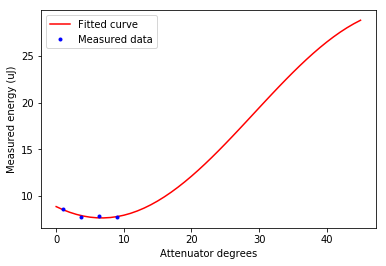

2018/04/11 17:33:53 find_sine_params(): Parameters found:
a + b * sin((x+c)*PI/45)
a = 18.85957075332423
b = 11.192495447322814
c = 60.766871234888704
-----------------------
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
2018/04/11 17:33:53 monitor_power(): Att value changed. Previous = 5.0, New value = 15.2, Previous power value = 8.609, New power value = 7.756, factor = 0.901
-----------------------
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
2018/04/11 17:33:53 monitor_power(): Att value changed. Previous = 3.0, New value = 16.9, Previous power value = 7.756, New power value = 6.433, factor = 0.829
-----------------------
2018/04/11 17:33:53 change_attenuator(): except clause entered in change_attenuator(): program closed or minimized
2018/04/11 17:33:53 monitor_power(): Att value changed. Previous = 0.0, New value = 16.6, Previous power value =

KeyboardInterrupt: 

In [7]:
monitor_power()

In [5]:
gen = line_get(file_get())
print(gen)
next(gen)

110420181523
Opening file: /home/eduardo/Desktop/Programming/Python/PLD control programs/new_system/2018-03-19_direct_att_control/110420181523
<generator object line_get at 0x7f07de324ba0>


'Data Log File:  110420181523\tRecipe:  \t04/11/2018\tNotes:  \n'

In [8]:
next(gen)

'15:24:15\t0.0000000000\t0.0000531000\t0.0439000018\t0.0005000000\t0.0000079100\t0.5271000266\t0.6399999857\t1000.0000000000\t820.0000000000\t100000.0000000000\t0.7329597473\t0.0415992737\t0.1199989319\t-0.0470390320\t0.0335998535\t20.0000000000\t0.0000000000\t0.0000000000\t0.0000000000\t-32768.0000000000\t-32768.0000000000\t0.0000000000\t0.0000000000\t0.0000000000\t0.5000000000\t-0.0000131664\t0.0000000000\t0.0000000000\t0.6841613650\t4.0000000000\t800.0000000000\t200.0000000000\t10000.0000000000\t10000.0000000000\t10000.0000000000\t0.0000000000\t0.0000000000\t0.0000000000\t20.0000000000\t61.4998016357\t0.0000000000\t-7.9997305870\t42.0000000000\t3.0000000000\t\t\t\t\n'

In [20]:
test = np.linspace(1,3,13)
for i in range(0, len(test)):
    test[i] = round(test[i], 2)

In [21]:
print(test)

[ 1.    1.17  1.33  1.5   1.67  1.83  2.    2.17  2.33  2.5   2.67  2.83
  3.  ]
